In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time

# Import your modules
from environment import LinearBanditEnv, SimulatedQuantumOracle
from oracles import StatisticalAEOracle
from agent import QSOFULAgent

# --- PLOTTING STYLE ---
sns.set_context("paper", font_scale=1.5)
sns.set_style("whitegrid")
colors = sns.color_palette("colorblind")

# --- BASELINE DEFINITION: STANDARD LINUCB ---
class StandardLinUCBAgent:
    """
    Classical Baseline: Ridge Regression + L2 Confidence Ball (Abbasi-Yadkori et al.)
    ignoring sparsity structure.
    """
    def __init__(self, d, alpha=1.0, lambda_reg=1.0):
        self.d = d
        self.alpha = alpha  # Exploration parameter
        self.lambda_reg = lambda_reg
        
        # Ridge State: V = sum(xxT) + lambda*I
        self.V = np.eye(self.d) * self.lambda_reg
        self.V_inv = np.eye(self.d) / self.lambda_reg
        self.b = np.zeros(self.d)
        self.theta_hat = np.zeros(self.d)
        
    def prepare_epoch(self):
        # LinUCB is usually "one step at a time", but to match the
        # Q-SOFUL api, we can just treat every step as an update opportunity.
        # We return dummy values to satisfy the experiment loop interface.
        return 0.1, 0.1, 1 

    def select_action(self):
        # 1. Estimate Theta
        self.theta_hat = self.V_inv @ self.b
        
        # 2. Maximize UCB: x^T theta + alpha * sqrt(x^T V^-1 x)
        # Exact max over [-1,1]^d is hard (convex maximization).
        # We use the same heuristic as Q-SOFUL: Check corners aligned with sign(theta)
        # plus some random corners for exploration.
        
        candidates = []
        # Corner A: greedy w.r.t theta
        candidates.append(np.sign(self.theta_hat))
        # Corner B: random corners
        for _ in range(10):
            candidates.append(np.random.choice([-1, 1], size=self.d))
            
        best_val = -np.inf
        best_x = np.zeros(self.d)
        
        for x in candidates:
            # UCB Score
            bonus = self.alpha * np.sqrt(x.T @ self.V_inv @ x)
            score = x.T @ self.theta_hat + bonus
            if score > best_val:
                best_val = score
                best_x = x
                
        return best_x, best_x # LinUCB plays the optimistic action directly

    def update_model(self, x_played, y_hat):
        # Sherman-Morrison update for V_inv is faster than O(d^3) inversion
        # (V + xxT)^-1 = V^-1 - (V^-1 x xT V^-1) / (1 + xT V^-1 x)
        x = x_played
        Vx = self.V_inv @ x
        denom = 1 + x.T @ Vx
        self.V_inv -= np.outer(Vx, Vx) / denom
        
        self.b += y_hat * x

In [2]:
def run_experiment(agent_class, d, s_star, Q_total, agent_params={}, oracle_type="simulated", seed=42):
    """
    Generic runner for both Q-SOFUL (and its subclasses) and LinUCB.
    """
    # 1. Setup Environment
    rng = np.random.default_rng(seed)
    
    if oracle_type == "physics":
        oracle = StatisticalAEOracle(rng=rng)
    else:
        oracle = SimulatedQuantumOracle(rng=rng)
        
    env = LinearBanditEnv(d=d, s_star=s_star, oracle=oracle, random_seed=seed)
    
    # 2. Setup Agent
    # FIX: Use issubclass to handle UnweightedQSOFULAgent correctly
    if issubclass(agent_class, QSOFULAgent):
        agent = agent_class(d=d, s_star=s_star, delta_tot=0.01, Q_total=Q_total, seed=seed, **agent_params)
    else:
        # For LinUCB, we must filter out QSOFUL-specific params to avoid TypeError
        valid_linucb_keys = {'alpha', 'lambda_reg'}
        filtered_params = {k: v for k, v in agent_params.items() if k in valid_linucb_keys}
        agent = StandardLinUCBAgent(d=d, **filtered_params)

    # 3. Interaction Loop
    total_cost = 0
    regret_cumulative = 0
    history_cost = []
    history_regret = []
    
    # Optimal action for regret calc
    x_opt = np.sign(env.theta_star)
    opt_val = env.true_reward(x_opt)
    
    pbar = tqdm(total=Q_total, desc=f"Sim d={d}", leave=False)
    
    while total_cost < Q_total:
        eps, delta, est_cost = agent.prepare_epoch()
        
        x_base, x_played = agent.select_action()
        
        # Handle epsilon for classical agents
        query_eps = eps if eps is not None else 0.1 
        query_delta = delta if delta is not None else 0.01
        
        y_hat, cost = env.get_reward_query(x_played, query_eps, query_delta)
        
        agent.update_model(x_played, y_hat)
        
        total_cost += cost
        inst_regret = opt_val - env.true_reward(x_played)
        regret_cumulative += inst_regret
        
        history_cost.append(total_cost)
        history_regret.append(regret_cumulative)
        
        pbar.update(cost)
        
    pbar.close()
    return np.array(history_cost), np.array(history_regret)

--- STARTING DIMENSION SCALING (Budget=2e+06) ---

Testing Dimension d=5...



Testing Dimension d=10...



Testing Dimension d=20...



Testing Dimension d=50...



Testing Dimension d=100...



Testing Dimension d=150...



Testing Dimension d=200...



Testing Dimension d=250...


Sim d=250:  54%|█████▍    | 1089692/2000000.0 [00:00<00:00, 6983459.28it/s]/opt/anaconda3/envs/qenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.350e-07, tolerance: 4.924e-07
  model = cd_fast.enet_coordinate_descent(



Testing Dimension d=300...


Sim d=300:   0%|          | 0/2000000.0 [00:00<?, ?it/s]/opt/anaconda3/envs/qenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.774e-06, tolerance: 1.715e-06
  model = cd_fast.enet_coordinate_descent(
Sim d=300:  38%|███▊      | 762844/2000000.0 [00:00<00:00, 5564753.38it/s]/opt/anaconda3/envs/qenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.080e-06, tolerance: 8.823e-07
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/qenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not con


Testing Dimension d=350...


Sim d=350:  19%|█▊        | 372969/2000000.0 [00:00<00:00, 1937097.09it/s]/opt/anaconda3/envs/qenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.049e-06, tolerance: 8.001e-07
  model = cd_fast.enet_coordinate_descent(
Sim d=350:  38%|███▊      | 762844/2000000.0 [00:00<00:00, 1771213.38it/s]/opt/anaconda3/envs/qenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.105e-06, tolerance: 4.570e-07
  model = cd_fast.enet_coordinate_descent(
Sim d=350:  54%|█████▍    | 1089692/2000000.0 [00:00<00:00, 2069874.16it/s]/opt/anaconda3/envs/qenv/lib/python3.11/site-packag


Testing Dimension d=400...


Sim d=400:  27%|██▋       | 533633/2000000.0 [00:00<00:00, 2482334.19it/s]/opt/anaconda3/envs/qenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.685e-07, tolerance: 5.094e-07
  model = cd_fast.enet_coordinate_descent(
Sim d=400:  27%|██▋       | 533633/2000000.0 [00:00<00:00, 2996762.56it/s]  /opt/anaconda3/envs/qenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.056e-06, tolerance: 1.026e-06
  model = cd_fast.enet_coordinate_descent(



Testing Dimension d=450...


Sim d=450:  54%|█████▍    | 1089692/2000000.0 [00:00<00:00, 1999235.03it/s]/opt/anaconda3/envs/qenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.286e-06, tolerance: 1.024e-06
  model = cd_fast.enet_coordinate_descent(
Sim d=450:  27%|██▋       | 533633/2000000.0 [00:00<00:01, 1265893.97it/s] /opt/anaconda3/envs/qenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.615e-07, tolerance: 2.503e-07
  model = cd_fast.enet_coordinate_descent(
Sim d=450:  38%|███▊      | 762844/2000000.0 [00:00<00:00, 1438729.86it/s]/opt/anaconda3/envs/qenv/lib/python3.11/site-packa


Testing Dimension d=500...


Sim d=500:  78%|███████▊  | 1555566/2000000.0 [00:00<00:00, 5805853.42it/s]/opt/anaconda3/envs/qenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.766e-07, tolerance: 1.201e-07
  model = cd_fast.enet_coordinate_descent(


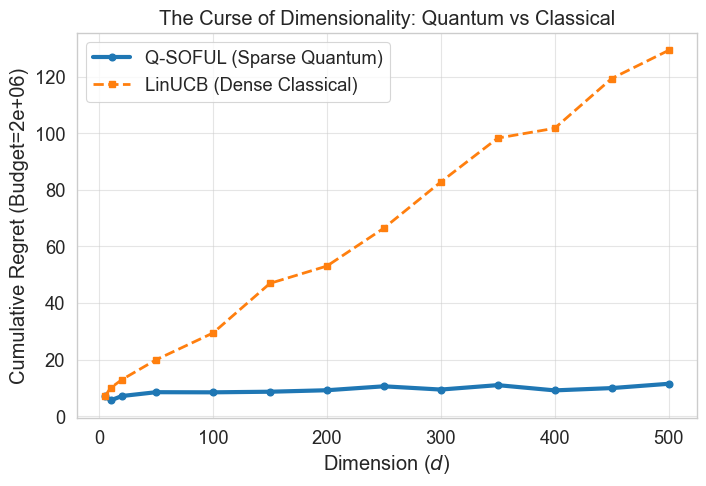

In [3]:
# --- EXPERIMENT SETTINGS ---
dimensions = [5,10,20,50,100, 150, 200, 250, 300, 350, 400, 450, 500] # Add 500 if you have time/CPU
Q_BUDGET = 2e6  # 2 Million Queries
S_STAR = 5      # Sparse Truth
TRIALS = 3      # Averaging for robustness

results = {
    "qsoful": {"d": [], "final_regret": []},
    "linucb": {"d": [], "final_regret": []}
}

print(f"--- STARTING DIMENSION SCALING (Budget={Q_BUDGET:.0e}) ---")

for d in dimensions:
    print(f"\nTesting Dimension d={d}...")
    
    # Run Q-SOFUL
    regrets_q = []
    for t in range(TRIALS):
        _, h_r = run_experiment(
            QSOFULAgent, d, S_STAR, Q_BUDGET, 
            agent_params={"alpha_scale": 0.5, "prefer_sklearn": True}, 
            seed=42+t
        )
        regrets_q.append(h_r[-1])
    
    results["qsoful"]["d"].append(d)
    results["qsoful"]["final_regret"].append(np.mean(regrets_q))
    
    # Run LinUCB
    regrets_c = []
    for t in range(TRIALS):
        _, h_r = run_experiment(
            StandardLinUCBAgent, d, S_STAR, Q_BUDGET,
            agent_params={"alpha": 0.5}, # Standard exploration
            seed=42+t
        )
        regrets_c.append(h_r[-1])
        
    results["linucb"]["d"].append(d)
    results["linucb"]["final_regret"].append(np.mean(regrets_c))

# --- PLOTTING ---
plt.figure(figsize=(8, 5))
plt.plot(results["qsoful"]["d"], results["qsoful"]["final_regret"], 
         marker='o', label='Q-SOFUL (Sparse Quantum)', linewidth=3)
plt.plot(results["linucb"]["d"], results["linucb"]["final_regret"], 
         marker='s', label='LinUCB (Dense Classical)', linestyle='--', linewidth=2)

plt.xlabel("Dimension ($d$)")
plt.ylabel(f"Cumulative Regret (Budget={Q_BUDGET:.0e})")
plt.title("The Curse of Dimensionality: Quantum vs Classical")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()


--- STARTING HORIZON SCALING (d=100) ---


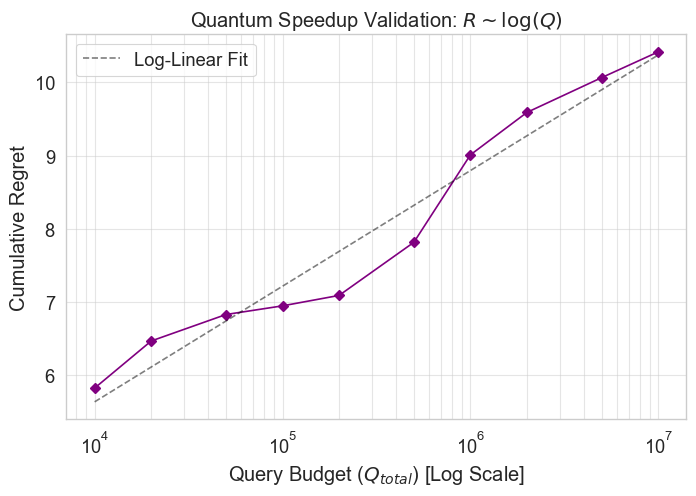

In [4]:
# --- EXPERIMENT SETTINGS ---
d_fixed = 100
budgets = [1e4, 2e4, 5e4, 1e5, 2e5, 5e5, 1e6, 2e6, 5e6, 1e7]
final_regrets = []

print(f"\n--- STARTING HORIZON SCALING (d={d_fixed}) ---")

for b in budgets:
    _, h_r = run_experiment(
        QSOFULAgent, d_fixed, S_STAR, b,
        agent_params={"alpha_scale": 0.5},
        seed=101
    )
    final_regrets.append(h_r[-1])

# --- PLOTTING ---
plt.figure(figsize=(8, 5))
# Log-Linear Plot
plt.semilogx(budgets, final_regrets, marker='D', color='purple', linestyle='-')

plt.xlabel("Query Budget ($Q_{total}$) [Log Scale]")
plt.ylabel("Cumulative Regret")
plt.title("Quantum Speedup Validation: $R \sim \log(Q)$")
plt.grid(True, which="both", ls="-", alpha=0.5)

# Add Trendline
z = np.polyfit(np.log(budgets), final_regrets, 1)
p = np.poly1d(z)
plt.plot(budgets, p(np.log(budgets)), "k--", alpha=0.5, label="Log-Linear Fit")
plt.legend()

plt.show()


--- STARTING SPARSITY SCALING (d=100) ---
Testing Sparsity s*=3...


Testing Sparsity s*=5...


Testing Sparsity s*=10...


Testing Sparsity s*=15...


Sim d=100:   0%|          | 0/1000000.0 [00:00<?, ?it/s]/opt/anaconda3/envs/qenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.269e-06, tolerance: 1.974e-07
  model = cd_fast.enet_coordinate_descent(


Testing Sparsity s*=20...


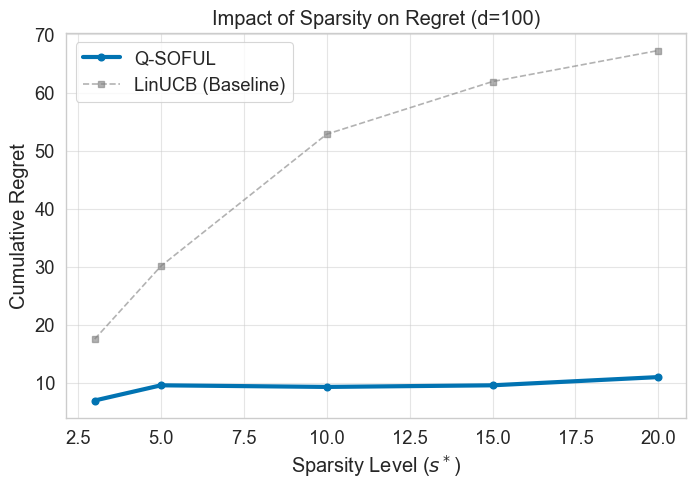

In [5]:
# --- EXPERIMENT 3: SPARSITY SCALING (s*) ---
# Theory Validation: Regret should scale linearly with s*

sparsities = [3, 5, 10, 15, 20]
d_fixed = 100
Q_BUDGET_S = 1e6  # 1 Million queries

results_sparsity = {
    "s": [], 
    "qsoful_regret": [],
    "linucb_regret": []
}

print(f"\n--- STARTING SPARSITY SCALING (d={d_fixed}) ---")

for s in sparsities:
    print(f"Testing Sparsity s*={s}...")
    
    # 1. Run Q-SOFUL (Sensitive to Sparsity)
    regrets_q = []
    for t in range(3):
        _, h_r = run_experiment(
            QSOFULAgent, d_fixed, s, Q_BUDGET_S, 
            agent_params={"alpha_scale": 0.5, "prefer_sklearn": True}, 
            seed=100+t
        )
        regrets_q.append(h_r[-1])
    
    results_sparsity["s"].append(s)
    results_sparsity["qsoful_regret"].append(np.mean(regrets_q))
    
    # 2. Run LinUCB (Indifferent to Sparsity, usually)
    regrets_c = []
    for t in range(3):
        _, h_r = run_experiment(
            StandardLinUCBAgent, d_fixed, s, Q_BUDGET_S,
            agent_params={"alpha": 0.5},
            seed=100+t
        )
        regrets_c.append(h_r[-1])

    results_sparsity["linucb_regret"].append(np.mean(regrets_c))

# --- PLOTTING ---
plt.figure(figsize=(8, 5))
plt.plot(results_sparsity["s"], results_sparsity["qsoful_regret"], 
         marker='o', label='Q-SOFUL', color=colors[0], linewidth=3)
plt.plot(results_sparsity["s"], results_sparsity["linucb_regret"], 
         marker='s', label='LinUCB (Baseline)', color='gray', linestyle='--', alpha=0.6)

plt.xlabel("Sparsity Level ($s^*$)")
plt.ylabel("Cumulative Regret")
plt.title(f"Impact of Sparsity on Regret (d={d_fixed})")
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

--- Running Robust Support Tracking (d=200, s*=5) ---


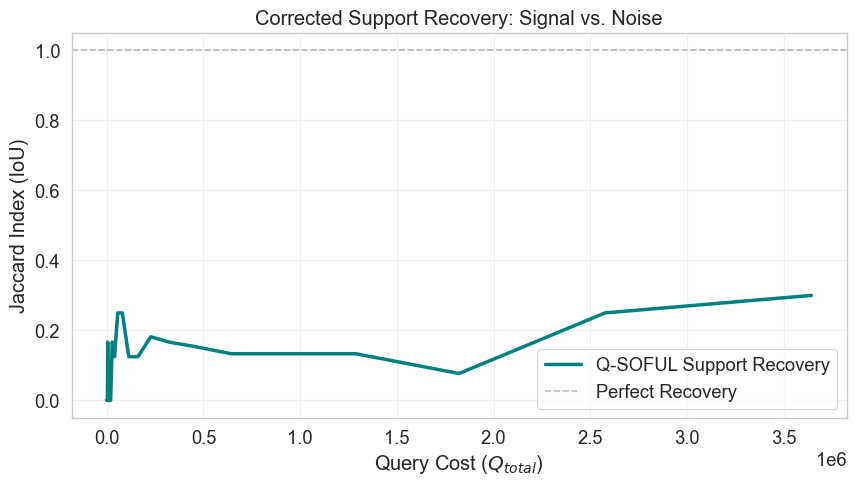

In [6]:
# --- IMPROVED EXPERIMENT 4: Support Recovery with Robust Thresholding ---

def run_robust_support_tracking(d=100, s_star=10, Q_total=2e8, seed=47):
    print(f"--- Running Robust Support Tracking (d={d}, s*={s_star}) ---")
    
    rng = np.random.default_rng(seed)
    
    # 1. Setup Environment
    # Use SimulatedOracle for speed in tracking dynamics
    oracle = SimulatedQuantumOracle(rng=rng)
    env = LinearBanditEnv(d=d, s_star=s_star, oracle=oracle, random_seed=seed)
    
    # 2. Setup Agent with STRONGER Solver settings
    # increasing max_iter is crucial for the ConvergenceWarning you saw
    agent = QSOFULAgent(
        d=d, s_star=s_star, delta_tot=0.01, Q_total=Q_total, seed=seed,
        alpha_scale=0.5,        # Standard scaling
        prefer_sklearn=True,
        lasso_max_iter=50000,   # FIX 1: Increase iterations to fix ConvergenceWarning
        lasso_tol=1e-5
    )
    
    true_support = set(np.where(np.abs(env.theta_star) > 1e-9)[0])
    
    history_cost = []
    history_iou = [] 
    
    total_cost = 0
    pbar = tqdm(total=Q_total, desc="Tracking Support", leave=False)
    
    while total_cost < Q_total:
        eps, _, _ = agent.prepare_epoch()
        x_base, x_played = agent.select_action()
        
        # Interaction
        y_hat, cost = env.get_reward_query(x_played, eps if eps else 0.1, 0.01)
        agent.update_model(x_played, y_hat)
        
        # --- FIX 2: ROBUST THRESHOLDING ---
        # Instead of 1e-9 (which picks up solver noise), use 1e-2.
        # The signal strength is ~1/s* = 0.2, so 0.01 is safely "noise".
        estimated_support = set(np.where(np.abs(agent.hat_theta) > 0.01)[0])
        
        # Calculate Jaccard Index (IoU)
        if len(true_support) == 0 and len(estimated_support) == 0:
            iou = 1.0
        else:
            intersection = len(true_support.intersection(estimated_support))
            union = len(true_support.union(estimated_support))
            iou = intersection / union if union > 0 else 0.0
            
        total_cost += cost
        history_cost.append(total_cost)
        history_iou.append(iou)
        
        pbar.update(cost)
        
    pbar.close()
    return history_cost, history_iou

# --- EXECUTION & PLOTTING ---
costs, ious = run_robust_support_tracking(d=200, s_star=5, Q_total=3e6)

plt.figure(figsize=(10, 5))
plt.plot(costs, ious, color='teal', linewidth=2.5, label='Q-SOFUL Support Recovery')
plt.axhline(1.0, color='grey', linestyle='--', alpha=0.5, label='Perfect Recovery')

plt.xlabel("Query Cost ($Q_{total}$)")
plt.ylabel("Jaccard Index (IoU)")
plt.title("Corrected Support Recovery: Signal vs. Noise")
plt.legend(loc='lower right')
plt.ylim(-0.05, 1.05)
plt.grid(True, alpha=0.3)
plt.show()

--- STARTING ABLATION STUDY (d=100) ---


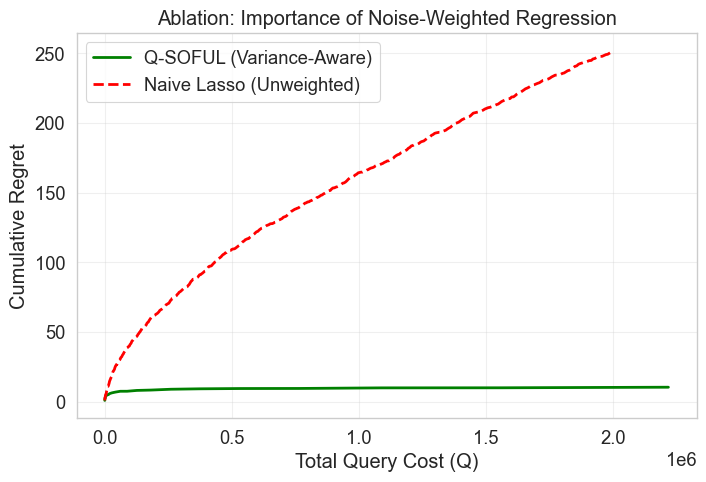

In [7]:
# --- EXPERIMENT 5: ABLATION STUDY (Variance-Weighted vs Unweighted) ---

class UnweightedQSOFULAgent(QSOFULAgent):
    """
    Control Group: A 'Naive' Quantum Agent that ignores the noise schedule.
    It forces the regression weights to be uniform (1.0).
    """
    def prepare_epoch(self):
        # 1. Run standard logic to get epsilon/delta
        eps, delta, est_cost = super().prepare_epoch()
        
        # 2. SABOTAGE: Force the regression weight to be 1.0 (Unweighted)
        # This ignores the fact that early samples are noisier than late samples.
        self.w_k = 1.0 
        
        return eps, delta, est_cost

d_ablation = 100
Q_ablation = 2e6

# --- CORRECTED ABLATION PLOTTING ---

print(f"--- STARTING ABLATION STUDY (d={d_ablation}) ---")

# 1. Capture Cost (h_c) AND Regret (h_r)
h_c_weighted, h_r_weighted = run_experiment(
    QSOFULAgent, d_ablation, 5, Q_ablation, 
    agent_params={"alpha_scale": 0.5, "lasso_max_iter": 50000},
    seed=42
)

h_c_unweighted, h_r_unweighted = run_experiment(
    UnweightedQSOFULAgent, d_ablation, 5, Q_ablation, 
    agent_params={"alpha_scale": 0.5, "lasso_max_iter": 50000}, 
    seed=42
)

# --- PLOTTING ---
plt.figure(figsize=(8, 5))

# FIX: Use h_c (Cost) for X-axis
plt.plot(h_c_weighted, h_r_weighted, label='Q-SOFUL (Variance-Aware)', color='green', linewidth=2)
plt.plot(h_c_unweighted, h_r_unweighted, label='Naive Lasso (Unweighted)', color='red', linestyle='--', linewidth=2)

plt.xlabel("Total Query Cost (Q)")  # Changed from Epochs
plt.ylabel("Cumulative Regret")
plt.title("Ablation: Importance of Noise-Weighted Regression")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()